In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.stats.api as sms
from datetime import datetime
from statsmodels.compat import lzip

### Production and Prices  Curtailment

In [18]:
dfs = []

# Loop through the years from 2015 to 2023
for i in range(2015, 2024):
    # Construct the file path for each year
    file_path = f'energy-charts_Public_net_electricity_generation_in_Germany_in_{i}.csv'
    
    # Read the CSV file for the current year and append to the list
    df = pd.read_csv(file_path, skiprows=[1]) 
    df['Hour'] = df['Date (GMT+1)'].str.split('T').str[1].str.split('+').str[0].str.split(':').str[0]
    df['Date'] = df['Date (GMT+1)'].str.split('T').str[0]
    # Convert 15-minute MW to hourly MW
    df_hourly = df.groupby(['Date', 'Hour']).sum()
    
    
    
    # Convert columns to numeric if they contain strings
    df_hourly[['Wind offshore','Wind onshore','Solar','Load']]
    # Divide the sum of power generation values by 4
    df_hourly[['Wind offshore','Wind onshore','Solar','Load']] = df_hourly[['Wind offshore','Wind onshore','Solar','Load']] / 4
    df_hourly.reset_index(inplace=True)
    
    
    df_hourly['Date'] = pd.to_datetime(df_hourly['Date'])

    # Convert 'Hour' column to string and pad single-digit hours with '0' to maintain a consistent format
    df_hourly['Hour'] = df_hourly['Hour'].astype(str).str.zfill(2)

    # Merge 'Date' and 'Hour' into a new column 'DateHour' and then drop 'Hour' column
    df_hourly['Date'] = df_hourly['Date'].dt.strftime('%Y-%m-%d') + ' ' + df_hourly['Hour'] + ':00:00'
    df_hourly['Date'] = pd.to_datetime(df_hourly['Date'])  # Convert to datetime format
    df_hourly = df_hourly.drop(columns=['Hour'])
    df_hourly.drop(columns=['Date (GMT+1)'], inplace=True)
    dfs.append(df_hourly)

# Concatenate all dataframes into a single dataframe
Power_production = pd.concat(dfs, ignore_index=True)
Renewable = Power_production[['Date','Wind offshore','Wind onshore','Solar','Load']] 

dfe = []

# Loop through the years from 2015 to 2023
for i in range(2015, 2024):
    # Construct the file path for each year
    file_path = f'energy-charts_Electricity_production_and_spot_prices_in_Germany_in_{i}.csv'
    
    # Read the CSV file for the current year and append to the list
    df = pd.read_csv(file_path, skiprows=[1])
    df['Hour'] = df['Date (GMT+1)'].str.split('T').str[1].str.split('+').str[0].str.split(':').str[0]
    df['Date'] = df['Date (GMT+1)'].str.split('T').str[0]
    df['Date'] = pd.to_datetime(df['Date'])

    # Convert 'Hour' column to string and pad single-digit hours with '0' to maintain a consistent format
    df['Hour'] = df['Hour'].astype(str).str.zfill(2)

    # Merge 'Date' and 'Hour' into a new column 'DateHour' and then drop 'Hour' column
    df['Date'] = df['Date'].dt.strftime('%Y-%m-%d') + ' ' + df['Hour'] + ':00:00'
    df['Date'] = pd.to_datetime(df['Date'])  # Convert to datetime format
    df = df.drop(columns=['Hour'])
    df.drop(columns=['Date (GMT+1)'], inplace=True)
    dfe.append(df)

# Concatenate all dataframes into a single dataframe
Power_prices = pd.concat(dfe, ignore_index=True)
#Power_prices = Power_prices[['Date','Day Ahead Auction']]
Power_DATA = pd.merge(Power_prices, Renewable, on='Date', how='inner')

###  Finding capture rates

In [19]:
# Step 1: Extract the date from the datetime column
Power_DATA['Date'] = pd.to_datetime(Power_DATA['Date']).dt.date

# Step 2: Group by date and calculate the total revenue and production for each renewable energy source
grouped = Power_DATA.groupby('Date').agg(
    TotalRevenueWindOffshore=('Wind offshore', lambda x: (x * Power_DATA.loc[x.index, 'Day Ahead Auction']).sum()),
    TotalProductionWindOffshore=('Wind offshore', 'sum'),
    TotalRevenueWindOnshore=('Wind onshore', lambda x: (x * Power_DATA.loc[x.index, 'Day Ahead Auction']).sum()),
    TotalProductionWindOnshore=('Wind onshore', 'sum'),
    TotalRevenueSolar=('Solar', lambda x: (x * Power_DATA.loc[x.index, 'Day Ahead Auction']).sum()),
    TotalProductionSolar=('Solar', 'sum'),
    TotalRevenueBaseload=('Load', lambda x: (x * Power_DATA.loc[x.index, 'Day Ahead Auction']).sum()),
    BaseloadProduction=('Load', 'sum')
)

# Step 3: Calculate the average price (capture price) for each renewable energy source
grouped['Capture_Price_WindOffshore'] = grouped['TotalRevenueWindOffshore'] / grouped['TotalProductionWindOffshore']
grouped['Capture_Price_WindOnshore'] = grouped['TotalRevenueWindOnshore'] / grouped['TotalProductionWindOnshore']
grouped['Capture_Price_Solar'] = grouped['TotalRevenueSolar'] / grouped['TotalProductionSolar']
grouped['Baseload_Price'] = grouped['TotalRevenueBaseload'] / grouped['BaseloadProduction']

# Step 4: Calculate the capture factor compared to baseload production
grouped['Capture_Factor_Wind_Offshore'] = grouped['Capture_Price_WindOffshore'] / grouped['Baseload_Price']
grouped['Capture_Factor_Wind_Onshore'] = grouped['Capture_Price_WindOnshore'] / grouped['Baseload_Price']
grouped['Capture_Factor_Solar'] = grouped['Capture_Price_Solar'] / grouped['Baseload_Price']
grouped.reset_index(inplace=True)

# Step 5: Display the results
Capture_factors = grouped[['Date','Capture_Factor_Wind_Offshore', 'Capture_Factor_Wind_Onshore', 'Capture_Factor_Solar']]
Capture_prices = grouped[['Date','Capture_Price_WindOffshore', 'Capture_Price_WindOnshore', 'Capture_Price_Solar','Baseload_Price']]
Capture_factors['Date'] = pd.to_datetime(Capture_factors['Date'])


# Set 'Date' column as the index
Capture_factors.set_index('Date', inplace=True)
percentage_change_df = Capture_factors.pct_change()
percentage_change_df = percentage_change_df.dropna()
percentage_change_df.reset_index(inplace=True)

C:\Users\Bruger\AppData\Local\Temp\ipykernel_15524\1778420417.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Capture_factors['Date'] = pd.to_datetime(Capture_factors['Date'])


### Volatility making it staionary 

In [20]:
# Convert Date to datetime format
Power_DATA['Date'] = pd.to_datetime(Power_DATA['Date'])

# Extract day, year, and month from the Date column
Power_DATA['Day'] = Power_DATA['Date'].dt.day
Power_DATA['Year'] = Power_DATA['Date'].dt.year
Power_DATA['Month'] = Power_DATA['Date'].dt.month

# Calculate the standard deviation of 'Day Ahead Auction' grouped by Year, Month, and Day
volatility = Power_DATA.groupby(['Year', 'Month', 'Day'])['Day Ahead Auction'].std()

# Weighted standard deviation
weighted_volatility = Power_DATA.groupby(['Year', 'Month', 'Day']).apply(
    lambda x: np.sqrt(np.average((x['Day Ahead Auction'] - x['Day Ahead Auction'].mean()) ** 2, weights=x['Load']))
)

# Make dataframe
volatility_reset = volatility.reset_index()
volatility_reset.columns = ['Year', 'Month', 'Day', 'Volatility']
volatility_reset['Date'] = pd.to_datetime(volatility_reset[['Year', 'Month', 'Day']])
volatility_reset = volatility_reset.drop(columns=['Year', 'Month', 'Day'])
volatility_reset


# Make dataframe
weighted_volatility_reset = weighted_volatility.reset_index()
weighted_volatility_reset.columns = ['Year', 'Month', 'Day', 'Weighted_volatility']
weighted_volatility_reset['Date'] = pd.to_datetime(weighted_volatility_reset[['Year', 'Month', 'Day']])
weighted_volatility_reset = weighted_volatility_reset.drop(columns=['Year', 'Month', 'Day'])
weighted_volatility_reset['Date'] = pd.to_datetime(weighted_volatility_reset['Date'])
weighted_volatility_reset['Weighted_volatility_adj'] = weighted_volatility_reset['Weighted_volatility'].pct_change().dropna()
weighted_volatility_reset = weighted_volatility_reset[['Date','Weighted_volatility_adj']]
weighted_volatility_reset.dropna(inplace=True)

### Merge and filtering

In [21]:
ANALYSE_DATA = pd.merge(percentage_change_df, weighted_volatility_reset, on='Date', how='inner')

def filter_dates_by_interval(data, column_name_solar, interval_start, interval_end, date):
    data['Date'] = pd.to_datetime(data['Date'])
    data = data[data['Date'] < date]
    filtered_dates = data[(data[column_name_solar] >= interval_start) & (data[column_name_solar] <= interval_end)]
    deleted_dates = data[~data.index.isin(filtered_dates.index)]  # Get dates not in filtered_dates
    print("Deleted Dates:")
    print(deleted_dates['Date'])
    return filtered_dates

column_name_solar = 'Capture_Factor_Solar'
interval_start = -1
interval_end = 1
date = pd.Timestamp(2023, 1, 1)

ANALYSE_DATA_F = filter_dates_by_interval(ANALYSE_DATA, column_name_solar, interval_start, interval_end, date)
ANALYSE_DATA_F.to_csv('OX_DATA.csv')
ANALYSE_DATA_F

### Plots

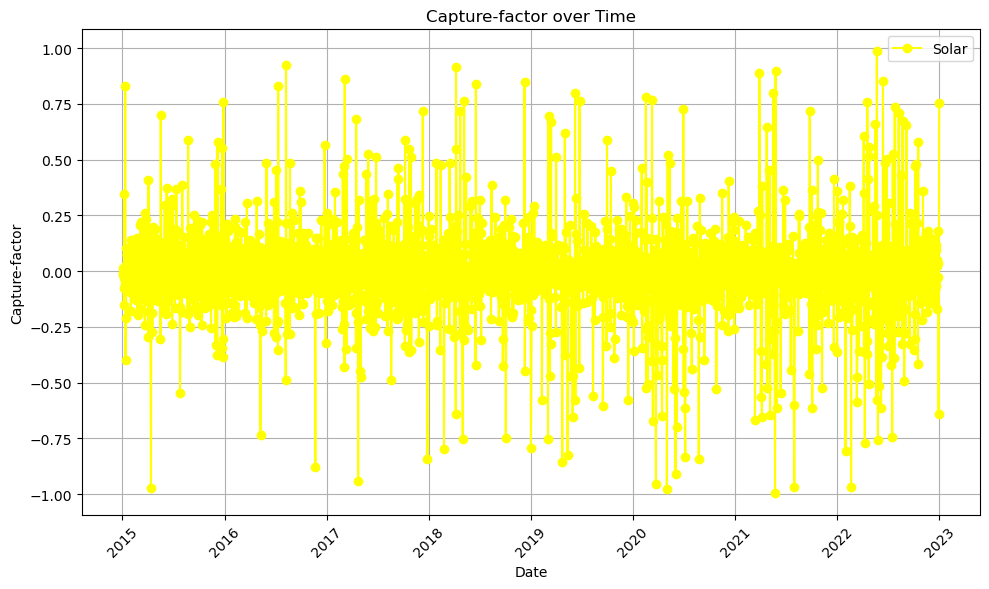

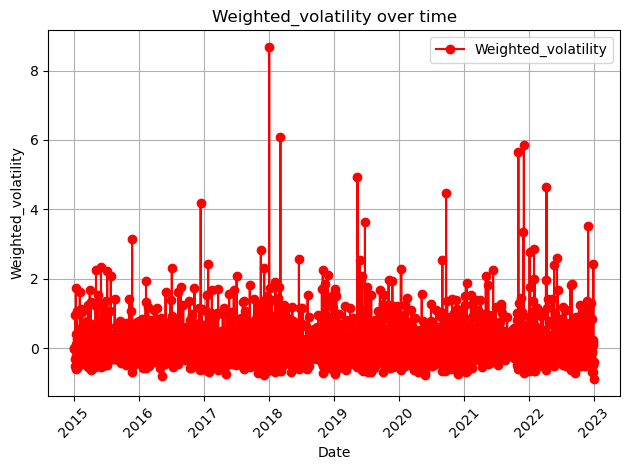

In [26]:
plt.figure(figsize=(10, 6))

plt.plot(ANALYSE_DATA_F['Date'], ANALYSE_DATA_F['Capture_Factor_Solar'], marker='o', color='yellow', linestyle='-', label='Solar')
#plt.plot(ANALYSE_DATA_F['Date'], ANALYSE_DATA_F['Capture_Factor_Wind_Offshore'], marker='o', color='blue', linestyle='-', label='MW Wind Offshore')
#plt.plot(ANALYSE_DATA_F['Date'], ANALYSE_DATA_F['Capture_Factor_Wind_Onshore'] , marker='o', color='lightblue', linestyle='-', label='MW Wind Onshore')

plt.title('Capture-factor over Time')
plt.xlabel('Date')
plt.ylabel('Capture-factor')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

plt.plot(ANALYSE_DATA_F['Date'], ANALYSE_DATA_F['Weighted_volatility_adj'], marker='o', color='red', linestyle='-', label='Weighted_volatility')

plt.title('Weighted_volatility over time')
plt.xlabel('Date')
plt.ylabel('Weighted_volatility')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

### Empirical analysis

In [28]:
# Define the independent variables including the constant
X = sm.add_constant(ANALYSE_DATA_F['Capture_Factor_Solar'])

# Define the dependent variable
y = ANALYSE_DATA_F['Weighted_volatility_adj']

# Fit the regression model
model = sm.RLM(y, X).fit()

# Print the summary of the model
print(model.summary())

                       Robust linear Model Regression Results                      
Dep. Variable:     Weighted_volatility_adj   No. Observations:                 2794
Model:                                 RLM   Df Residuals:                     2792
Method:                               IRLS   Df Model:                            1
Norm:                               HuberT                                         
Scale Est.:                            mad                                         
Cov Type:                               H1                                         
Date:                     Wed, 28 Feb 2024                                         
Time:                             14:39:40                                         
No. Iterations:                         28                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

In [21]:
# Assuming you have your data in a DataFrame called 'ANALYSE_DATA'

# Define the independent variable including the constant
X = sm.add_constant(ANALYSE_DATA['Capture_Factor_Solar	'])

# Define the dependent variable
y = ANALYSE_DATA['Weighted_volatility_adj']

# Fit the robust linear regression model
model = sm.RLM(y, X).fit()

# Print the summary of the model
print(model.summary())

# Residuals
residuals = model.resid


# Perform Breusch-Pagan test for heteroscedasticity
name = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
#test = sm.stats.diagnostic.het_breuschpagan(residuals, X)
#print("Breusch-Pagan Test (LM, p-value, f-value, f p-value):", test)

# Perform Durbin-Watson test for autocorrelation
durbin_watson_statistic = sm.stats.stattools.durbin_watson(residuals)
print("Durbin-Watson Statistic:", durbin_watson_statistic)

# Perform Jarque-Bera test for normality
jarque_bera_test = sm.stats.stattools.jarque_bera(residuals)
#print("Jarque-Bera Test (JB, JB p-value, skewness, kurtosis):", jarque_bera_test)

plt.show()

                       Robust linear Model Regression Results                      
Dep. Variable:     Weighted_volatility_adj   No. Observations:                 2191
Model:                                 RLM   Df Residuals:                     2189
Method:                               IRLS   Df Model:                            1
Norm:                               HuberT                                         
Scale Est.:                            mad                                         
Cov Type:                               H1                                         
Date:                     Wed, 28 Feb 2024                                         
Time:                             14:02:06                                         
No. Iterations:                         24                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------